In [ ]:
# !pip install np_utils

In [ ]:
# !rm -rf /content/Positive

In [ ]:
# !rm -rf /content/Negative

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oluwaseunad/concrete-and-pavement-crack-images

100% 318M/319M [00:11<00:00, 36.5MB/s]
100% 319M/319M [00:11<00:00, 29.9MB/s]


In [ ]:
!unzip -q concrete-and-pavement-crack-images.zip

In [ ]:
!ls

concrete-and-pavement-crack-images.zip	kaggle.json  Negative  Positive  sample_data


In [ ]:
neg_path = '/content/Negative'

In [ ]:
pos_path = '/content/Positive'

In [ ]:
#using  Cycle GAN architecture

In [ ]:
# Discriminator model

class Block(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,stride,1,bias=True,padding_mode='zeros'),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(0.2),
    )

  def forward(self,x):
    return self.conv(x)

In [ ]:
# Discriminator model

class Discriminator(nn.Module):
  def __init__(self,in_channels = 3, features =[64,128,256,512]):
    super().__init__()
    self.initial= nn.Sequential(
        nn.Conv2d(in_channels,features[0],kernel_size=4,stride=2,padding=1,padding_mode='zeros'),
        nn.ReLU(0.2),
    )
    layers=[]
    in_channels=features[0]
    for feature in features[1:]:
      layers.append(Block(in_channels,feature,stride=1 if feature == features[-1] else 2))
      in_channels = feature
    layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='zeros'))
    self.model=nn.Sequential(*layers)
    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(494, 256)
    self.leakyrelu1 = nn.LeakyReLU(0.1)
    self.dropout = nn.Dropout(0.2)
    self.dense2 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()




  def forward(self, x):
      x = self.initial(x)
      x = self.model(x)
      x = self.flatten(x)
      # print(x.shape)
      x = self.dense1(x)
      x = self.leakyrelu1(x)
      x = self.dropout(x)
      x = self.dense2(x)
      x = self.sigmoid(x)
      return x

In [ ]:
# Discriminator model test

x=torch.randn((1,3,227,170))
model = Discriminator()
preds=model(x)
print(model)
print(preds.shape)
print(preds)

Discriminator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (model): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (3): Conv2d(512, 1, kern

In [ ]:
# # generator model


# class ConvBlock(nn.Module):
#   def __init__(self,in_channels,out_channels,down=True,use_act=True,**kwargs):
#     super().__init__()
#     self.conv = nn.Sequential(
#         nn.Conv2d(in_channels,out_channels,padding_mode='reflect',**kwargs)
#         if down
#         else nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
#         nn.InstanceNorm2d(out_channels),
#         nn.ReLU(inplace = True) if use_act else nn.Identity()
#     )

#   def forward(self,x):
#     return self.conv(x)

In [ ]:
# # generator model

# class ResidualBlock(nn.Module):
#   def __init__(self,channels):
#     super().__init__()
#     self.block = nn.Sequential(
#         ConvBlock(channels,channels,kernel_size=3,padding=1),
#         ConvBlock(channels,channels,use_act=False, kernel_size=3,padding=1),
#     )

#   def forward(self,x):
#     return x + self.block(x)


In [ ]:
# class Generator(nn.Module):
#   def __init__(self, img_channels, num_features=64, num_residuals=9):
#       super(Generator, self).__init__()
#       self.initial = nn.Sequential(
#           nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
#           nn.ReLU(inplace=True)
#       )

#       self.down_blocks = nn.ModuleList([
#           ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
#           ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)
#       ])

#       self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features*4) for _ in range(num_residuals)])

#       self.up_blocks = nn.ModuleList([
#           ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
#           ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
#       ])

#       self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')

#   def forward(self, x):
#       x = self.initial(x)
#       for layer in self.down_blocks:
#           x = layer(x)
#       x = self.residual_blocks(x)
#       for layer in self.up_blocks:
#           x = layer(x)
#       return torch.tanh(self.last(x))


In [ ]:
# img_channels = 3
# x=torch.randn((2,img_channels,227,170))
# gen=Generator(img_channels)
# print(gen)
# print(gen(x).shape)

In [ ]:
# #Normal Discriminator model

# class Discriminator(nn.Module):
#   def __init__(self,img_dim):
#     super().__init__()
#     self.disc = nn.Sequential(
#         nn.Linear(img_dim,64),
#         nn.LeakyReLU(0.1),
#         nn.Linear(64,128),
#         nn.LeakyReLU(0.1),
#         nn.Linear(128,1),
#         nn.Sigmoid(),

#     )
#   def forward(self,x):
#     return self.disc(x)

In [ ]:
# img_channels = 1
# img_height = 277
# image_width = 170
# x=torch.randn((2,img_channels,img_height*image_width))
# dis=Discriminator(img_height*image_width)
# print(dis)
# print(dis(x).shape)
# print(dis(x))

In [ ]:
# class Generator(nn.Module):
#   def __init__(self,z_dim,img_dim):
#     super().__init__()
#     self.gen = nn.Sequential(
#         nn.Linear(z_dim,64),
#         nn.LeakyReLU(0.1),
#         nn.Linear(64,256),
#         nn.LeakyReLU(0.1),
#         nn.Linear(256,img_dim),
#         nn.Tanh(),
#     )

#   def forward(self,x):
#     return self.gen(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_channels=3, img_height=227, img_width=170):
        super().__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width

        self.gen = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_channels * img_height * img_width),
            nn.Tanh()
        )

    def forward(self, x):
        # Generate images
        img = self.gen(x)
        # Reshape the output to match the desired shape [batch_size, channels, height, width]
        img = img.view(-1, self.img_channels, self.img_height, self.img_width)
        return img


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Hyperparamaters
lr = 3e-4
z_dim = 64
image_dim = 227*170*1
batch_size = 32
num_epoch = 50
img_channels=3
img_height=227
img_width=170

In [ ]:
# import shutil

# # Source and destination paths
# source_folder_positive = "/content/Positive"
# destination_folder = "/content/root/positive"

# # Move positive folder to root folder
# shutil.move(source_folder_positive, destination_folder)



In [ ]:
disc = Discriminator().to(device)
gen = Generator(z_dim, img_channels, img_height, img_width).to(device)
fixed_noise = torch.rand((batch_size,z_dim)).to(device)

transform  = transforms.Compose(
    [
        # transforms.ToPILImage(),  # Convert tensor to PIL Image
        # transforms.Grayscale(num_output_channels=1),  # Convert to single-channel (grayscale)
        transforms.ToTensor(),
        transforms.Normalize((0.0,),(0.5,)),
        transforms.Resize((227, 170))
    ]
)
# Path to your dataset directory
dataset_root = "/content/root"

# Create ImageFolder dataset instance
custom_dataset = ImageFolder(root=dataset_root, transform=transform)
loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

opt_disc = optim.Adam(disc.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

Epoch [0/50], Batch Step [0/469], Loss D: 0.7054, Loss G: 1.9805


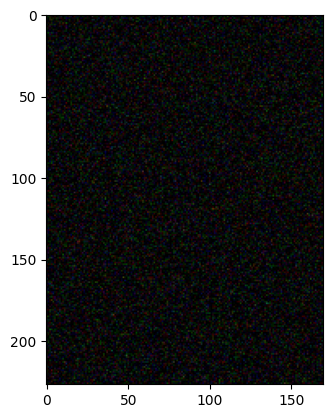

Epoch [1/50], Batch Step [0/469], Loss D: 0.1902, Loss G: 1.4720


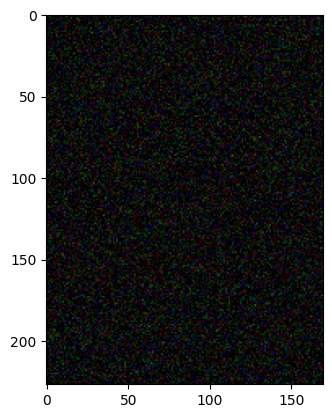

Epoch [2/50], Batch Step [0/469], Loss D: 0.1863, Loss G: 1.3668


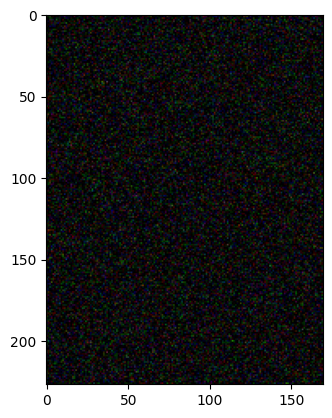

Epoch [3/50], Batch Step [0/469], Loss D: 0.1543, Loss G: 1.7094


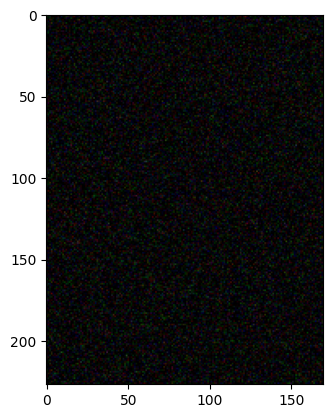

Epoch [4/50], Batch Step [0/469], Loss D: 0.2211, Loss G: 1.1991


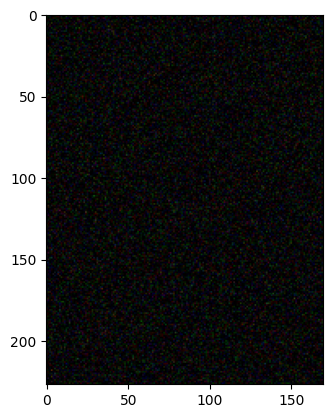

Epoch [5/50], Batch Step [0/469], Loss D: 0.1396, Loss G: 1.6548


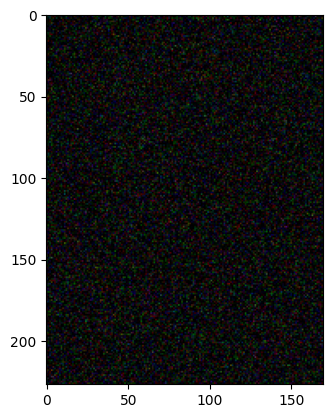

Epoch [6/50], Batch Step [0/469], Loss D: 0.1526, Loss G: 1.4632


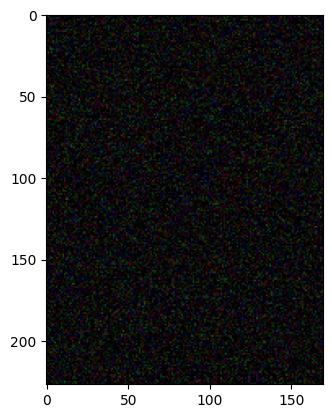

Epoch [7/50], Batch Step [0/469], Loss D: 0.1915, Loss G: 1.3076


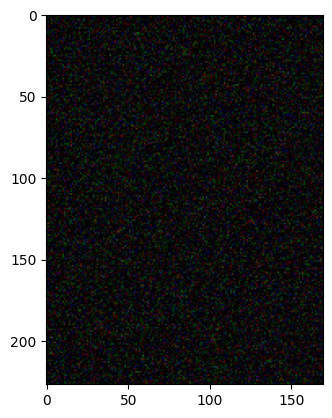

Epoch [8/50], Batch Step [0/469], Loss D: 0.1899, Loss G: 1.3172


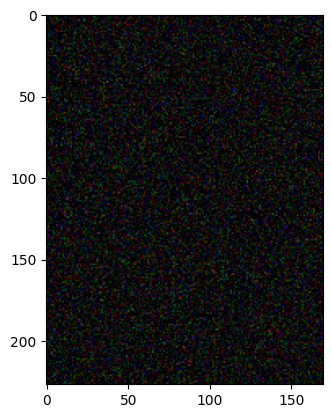

Epoch [9/50], Batch Step [0/469], Loss D: 0.1845, Loss G: 1.4321


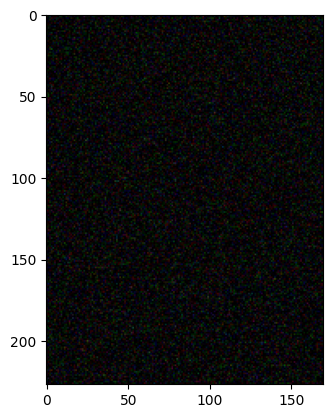

Epoch [10/50], Batch Step [0/469], Loss D: 0.1584, Loss G: 1.4292


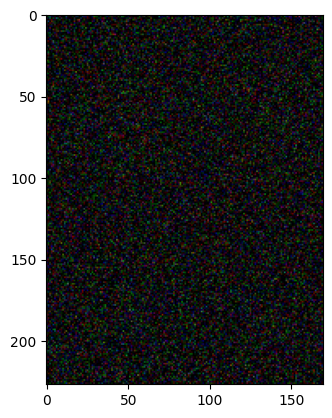

Epoch [11/50], Batch Step [0/469], Loss D: 0.1427, Loss G: 1.6744


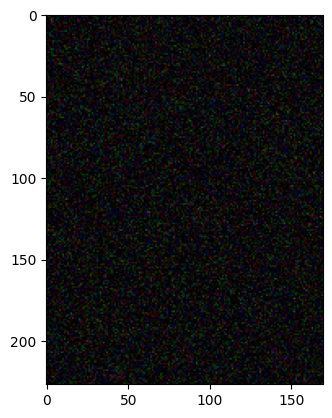

Epoch [12/50], Batch Step [0/469], Loss D: 0.1730, Loss G: 1.3903


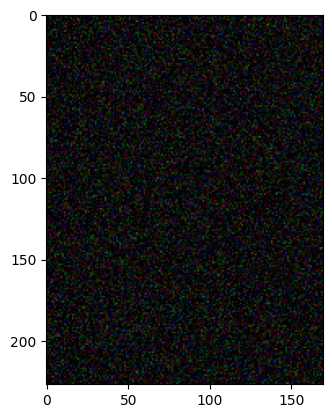

Epoch [13/50], Batch Step [0/469], Loss D: 0.1536, Loss G: 1.4332


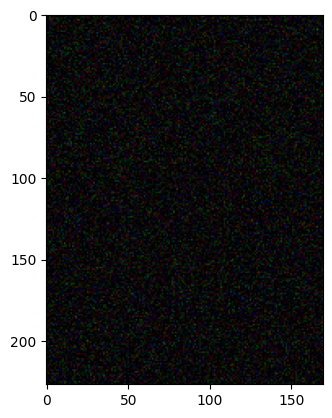

Epoch [14/50], Batch Step [0/469], Loss D: 0.1487, Loss G: 1.4715


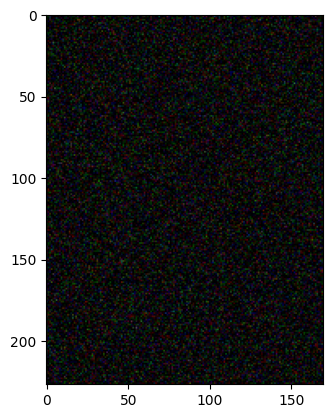

Epoch [15/50], Batch Step [0/469], Loss D: 0.1660, Loss G: 1.3785


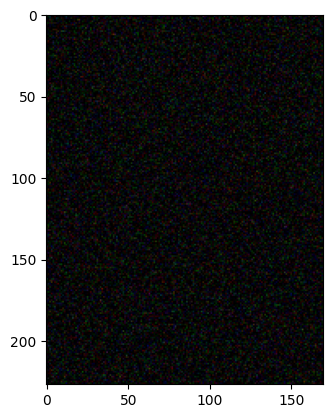

Epoch [16/50], Batch Step [0/469], Loss D: 0.1574, Loss G: 1.4845


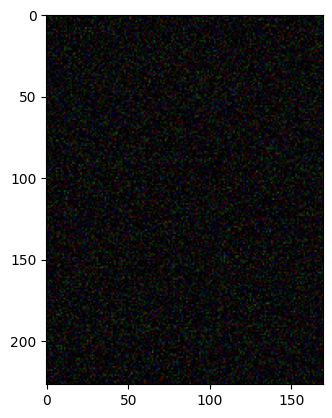

Epoch [17/50], Batch Step [0/469], Loss D: 0.2126, Loss G: 1.3736


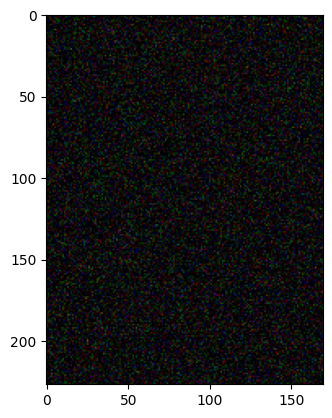

In [ ]:
step = 0
for epoch in range(num_epoch):
  for batch_idx,(real,_) in enumerate(loader):

    batch_size = real.shape[0]
    # print(batch_size)
    real = real.to(device)
    # print("Real Shape :" + str(real.shape))   #[32, 3, 227, 170]

    #Discriminator : max log(D(real)) + log(1-D(G(z)))

    # Define the size tuple for the noise tensor

    # Generate noise tensor with the specified size
    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise)   # z_dim, img_channels, img_height, img_width):
    disc_real = disc(real)
    # print(disc_real.shape)
    lossD_real = criterion(disc_real,torch.ones_like(disc_real))
    disc_fake = disc(fake)
    lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake)/2
    disc.zero_grad()
    lossD.backward(retain_graph = True)
    opt_disc.step()

    # Train Generator min log(1-D(G(z)))
    output = disc(fake).view(-1)
    lossG = criterion(output,torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    #Plotting
    if batch_idx % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epoch}], Batch Step [{batch_idx}/{len(loader)}], Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

        # Plot the generated images
        fig, ax = plt.subplots()
        ax.imshow(fake[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

        plt.show()